In [41]:
import cv2
import os
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import random

minmaxscaler = MinMaxScaler()

In [42]:
dataset_root_folder = 'E:\\DADA\\Deep Learning for Building Extraction\\Dataset'
dataset_name = 'Semantic segmentation dataset'

In [43]:
image_patchsize = 256

In [44]:
image_dataset = []
mask_dataset = []

for image_type in ['images', 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
    image_extension = 'png'
  for tile_id in range(1,9):
    #print(tile_id)
    for image_id in range(20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}')
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patchsize)*image_patchsize
        size_y = (image.shape[0]//image_patchsize)*image_patchsize
        #print("{}--------{}--{}".format(image.shape, size_y, size_x))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({}, {})".format(image.size[0], image.size[1]))
        image = np.array(image) #putting back to numpy array
        patched_images = patchify(image, (image_patchsize, image_patchsize, 3), step=image_patchsize)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = (minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1]))).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0] # This is the final format of input image to be used.
            #print(individual_patched_image)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)

In [45]:
print(len(image_dataset))
print(len(mask_dataset))

1305
1305


In [46]:
image_dataset = np.array(image_dataset, dtype=np.float32)
mask_dataset = np.array(mask_dataset, dtype=np.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


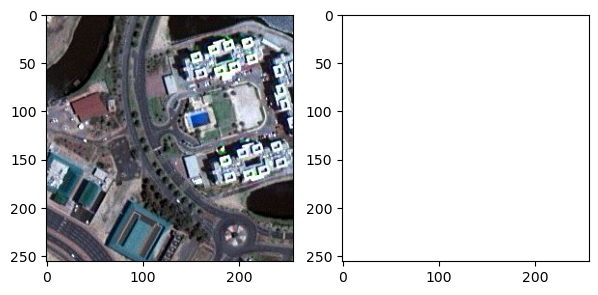

In [47]:
random_im_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(7,4))
plt.subplot(121)
plt.imshow(image_dataset[random_im_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_im_id])

In [48]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))

class_veg = '#FEDD3A'
class_veg = class_veg.lstrip('#')
class_veg = np.array(tuple(int(class_veg[i:i+2], 16) for i in (0,2,4)))

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))

In [49]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_veg, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  label_segment = label_segment[:,:,0]
  return label_segment

In [50]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)
labels = np.array(labels)

In [51]:
labels = np.expand_dims(labels, axis=3)

In [52]:
total_classes = len(np.unique(labels))

In [53]:
master_training_dataset = image_dataset

In [54]:
from keras.utils import to_categorical

In [55]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
x_train, x_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [58]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1109, 256, 256, 3)
(196, 256, 256, 3)
(1109, 256, 256, 6)
(196, 256, 256, 6)


In [59]:
image_height = x_train.shape[1]
image_width = x_train.shape[2]
image_channels = x_train.shape[3]
total_classes = y_train.shape[3]

In [60]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [61]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [62]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [63]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=3):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [64]:
metrics = ["accuracy", jaccard_coef]

In [65]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

In [66]:
model = get_deep_learning_model()

In [67]:
model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   'config': {'name': '

In [68]:
weights = [0.166,0.166,0.166,0.166,0.166,0.166]

In [69]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

In [70]:
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [71]:
import tensorflow as tf

In [72]:
tf.keras.backend.clear_session()

In [73]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [74]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [75]:
model_history = model.fit(x_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=100,
                          validation_data=(x_test, y_test),
                          shuffle=False)

Epoch 1/100
70/70 [==============================] - 247s 3s/step - loss: 0.9911 - accuracy: 0.5737 - jaccard_coef: 0.3032 - val_loss: 0.9811 - val_accuracy: 0.6310 - val_jaccard_coef: 0.4180
Epoch 2/100
70/70 [==============================] - 241s 3s/step - loss: 0.9655 - accuracy: 0.6814 - jaccard_coef: 0.4189 - val_loss: 0.9674 - val_accuracy: 0.7145 - val_jaccard_coef: 0.4508
Epoch 3/100
70/70 [==============================] - 239s 3s/step - loss: 0.9553 - accuracy: 0.7255 - jaccard_coef: 0.4703 - val_loss: 0.9547 - val_accuracy: 0.7430 - val_jaccard_coef: 0.4970
Epoch 4/100
70/70 [==============================] - 236s 3s/step - loss: 0.9481 - accuracy: 0.7485 - jaccard_coef: 0.5049 - val_loss: 0.9572 - val_accuracy: 0.7297 - val_jaccard_coef: 0.5165
Epoch 5/100
70/70 [==============================] - 230s 3s/step - loss: 0.9397 - accuracy: 0.7732 - jaccard_coef: 0.5482 - val_loss: 0.9548 - val_accuracy: 0.7496 - val_jaccard_coef: 0.5397
Epoch 6/100
70/70 [=====================

In [86]:
import pickle
# Save the history object
with open('E:\\DADA\\Deep Learning for Building Extraction\\initial_training_history.pkl', 'wb') as f:
    pickle.dump(model_history.history, f)


In [77]:
history = model_history

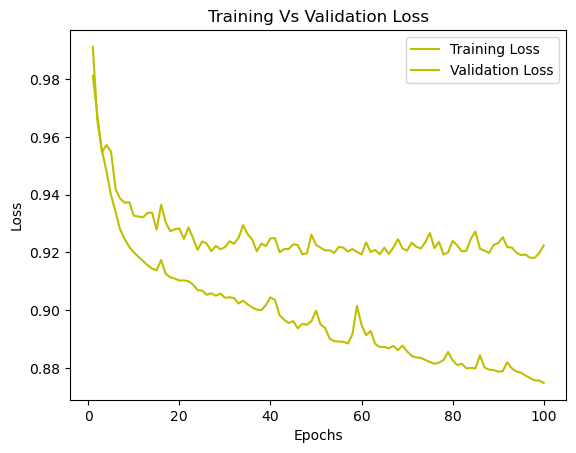

In [78]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="Training Loss")
plt.plot(epochs,val_loss,'y',label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [79]:
y_pred = model.predict(x_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

7/7 [==============================] - 8s 757ms/step


In [80]:
import random

In [111]:
test_image_number = random.randint(0, len(x_test))

test_image = x_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]
test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 57ms/step


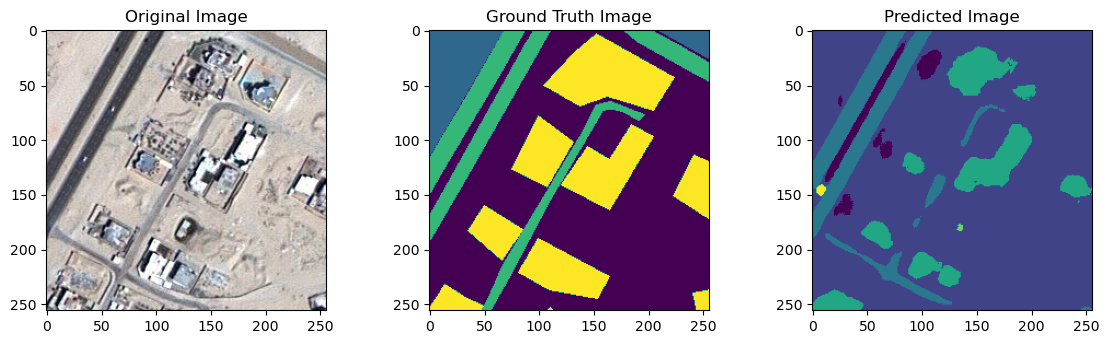

In [112]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Ground Truth Image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [83]:
model.save('E:\\DADA\\Deep Learning for Building Extraction\\my_model')

INFO:tensorflow:Assets written to: E:\DADA\Deep Learning for Building Extraction\my_model\assets


INFO:tensorflow:Assets written to: E:\DADA\Deep Learning for Building Extraction\my_model\assets


In [84]:
model.save_weights('E:\\DADA\\Deep Learning for Building Extraction\\my_model_weights.ckpt')

In [85]:
from tensorflow.keras.models import model_from_json

# Load the model architecture from JSON file
with open("E:\\DADA\\Deep Learning for Building Extraction\\my_model.json", 'r') as json_file:
    model_json = json_file.read()
    model = model_from_json(model_json)

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\DADA\\Deep Learning for Building Extraction\\my_model.json'

In [5]:
model.load_weights('E:\\DADA\\Deep Learning for Building Extraction\\my_model_weights.ckpt')